In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_normal = 5000
n_attack = 1500

# Normal traffic
normal_data = pd.DataFrame({
    "packet_rate": np.random.normal(50, 10, n_normal),
    "function_code_freq": np.random.normal(5, 1, n_normal),
    "response_time_ms": np.random.normal(120, 20, n_normal),
    "error_flag": np.zeros(n_normal),
    "label": np.zeros(n_normal)
})

# Attack traffic
attack_data = pd.DataFrame({
    "packet_rate": np.random.normal(200, 40, n_attack),
    "function_code_freq": np.random.normal(15, 4, n_attack),
    "response_time_ms": np.random.normal(350, 80, n_attack),
    "error_flag": np.ones(n_attack),
    "label": np.ones(n_attack)
})

# Combine
df = pd.concat([normal_data, attack_data], ignore_index=True)

df.head(), df.shape


(   packet_rate  function_code_freq  response_time_ms  error_flag  label
 0    54.967142            4.576240        106.430105         0.0    0.0
 1    48.617357            4.546586        113.890011         0.0    0.0
 2    56.476885            3.204357        108.052379         0.0    0.0
 3    65.230299            4.669910        122.208361         0.0    0.0
 4    47.658466            5.732829        143.943571         0.0    0.0,
 (6500, 5))

In [3]:
df['label'].value_counts()


label
0.0    5000
1.0    1500
Name: count, dtype: int64

In [4]:
df.to_csv("../data/processed/ics_synthetic_network_data.csv", index=False)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((4875, 4), (1625, 4))

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1250
         1.0       1.00      1.00      1.00       375

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



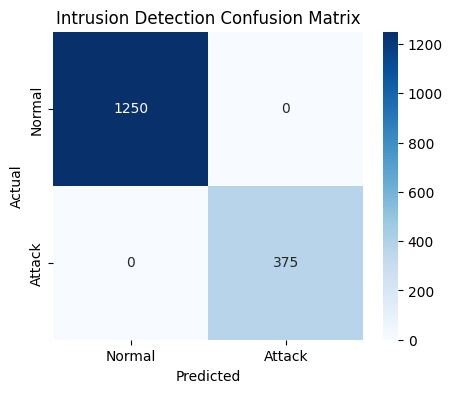

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Intrusion Detection Confusion Matrix")
plt.show()


In [7]:
plt.savefig("../outputs/confusion_matrix.png")


<Figure size 640x480 with 0 Axes>

In [8]:
# Phase 1: Multi-class attack model
# Train model

In [10]:
import numpy as np
import pandas as pd

df = df.copy()

# Remove old binary label
df = df.drop(columns=["label"])

np.random.seed(42)

labels = []
attack_type = []

for _, row in df.iterrows():
    r = np.random.rand()

    if r < 0.75:
        # Normal
        labels.append(0)
        attack_type.append("Normal")

    elif r < 0.85:
        # Reconnaissance
        df.loc[_, "packet_rate"] *= np.random.uniform(1.2, 1.5)
        df.loc[_, "function_code_freq"] *= np.random.uniform(1.3, 1.6)
        labels.append(1)
        attack_type.append("Reconnaissance")

    elif r < 0.95:
        # DoS
        df.loc[_, "packet_rate"] *= np.random.uniform(2.5, 4.0)
        df.loc[_, "response_time_ms"] *= np.random.uniform(2.0, 3.5)
        df.loc[_, "error_flag"] = 1
        labels.append(2)
        attack_type.append("DoS")

    else:
        # Protocol Abuse
        df.loc[_, "function_code_freq"] *= np.random.uniform(2.0, 3.0)
        df.loc[_, "error_flag"] = 1
        labels.append(3)
        attack_type.append("Protocol Abuse")

df["label"] = labels
df["attack_type"] = attack_type


In [11]:
df["attack_type"].value_counts()


attack_type
Normal            4917
DoS                657
Reconnaissance     607
Protocol Abuse     319
Name: count, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["attack_encoded"] = le.fit_transform(df["attack_type"])


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=["label", "attack_type", "attack_encoded"])
y = df["attack_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))


                precision    recall  f1-score   support

           DoS       1.00      0.99      1.00       164
        Normal       0.99      1.00      1.00      1229
Protocol Abuse       0.99      0.99      0.99        80
Reconnaissance       0.98      0.95      0.97       152

      accuracy                           0.99      1625
     macro avg       0.99      0.98      0.99      1625
  weighted avg       0.99      0.99      0.99      1625



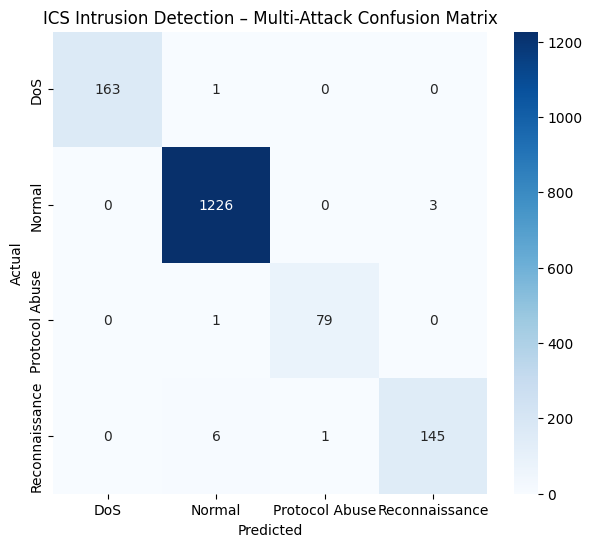

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ICS Intrusion Detection – Multi-Attack Confusion Matrix")
plt.show()


In [ ]:
## Phase 2: Enhanced Multi-Class ICS Attack Detection


In [16]:
noise_factor = 0.05  # 5% variation
for col in ["packet_rate", "function_code_freq", "response_time_ms"]:
    df[col] = df[col] * (1 + np.random.normal(0, noise_factor, size=len(df)))


In [17]:
normal_df = df[df.attack_type=="Normal"]
dos_df = df[df.attack_type=="DoS"].sample(frac=0.4, random_state=42)
pa_df = df[df.attack_type=="Protocol Abuse"].sample(frac=0.4, random_state=42)
recon_df = df[df.attack_type=="Reconnaissance"]

df_balanced = pd.concat([normal_df, dos_df, pa_df, recon_df])


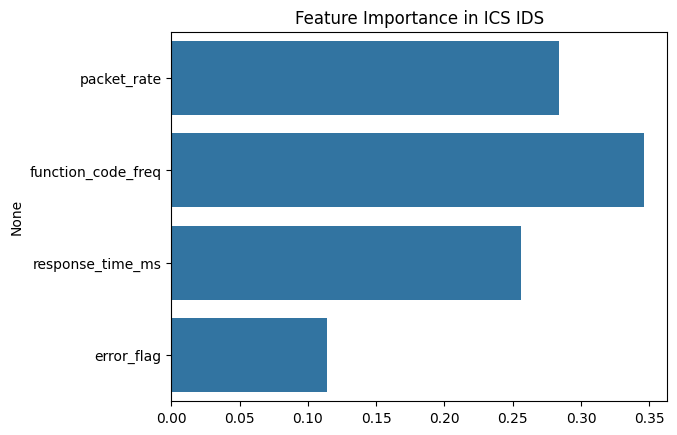

In [18]:
importances = model.feature_importances_
feat_names = X_train.columns
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance in ICS IDS")
plt.show()


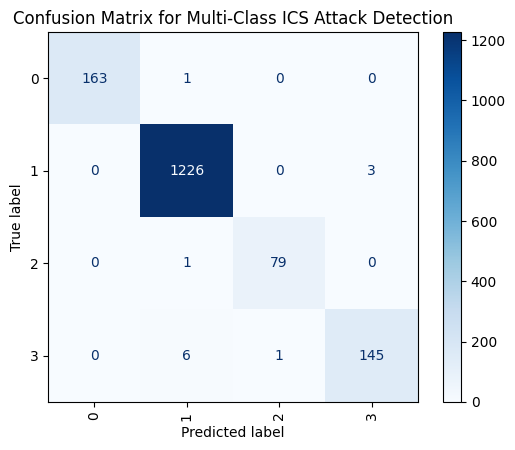

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix for Multi-Class ICS Attack Detection")
plt.show()


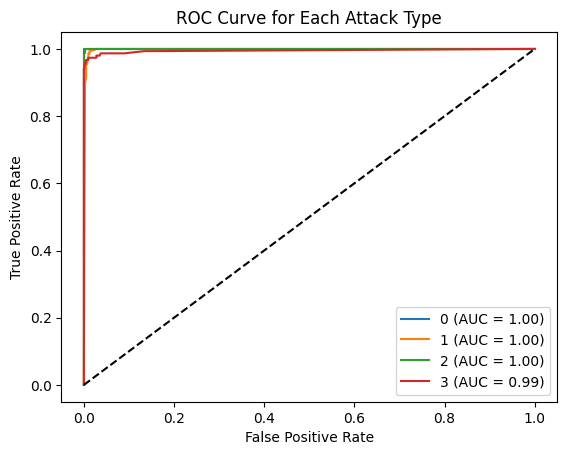

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=model.classes_)
y_score = model.predict_proba(X_test)

for i, cls in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Attack Type")
plt.legend()
plt.show()


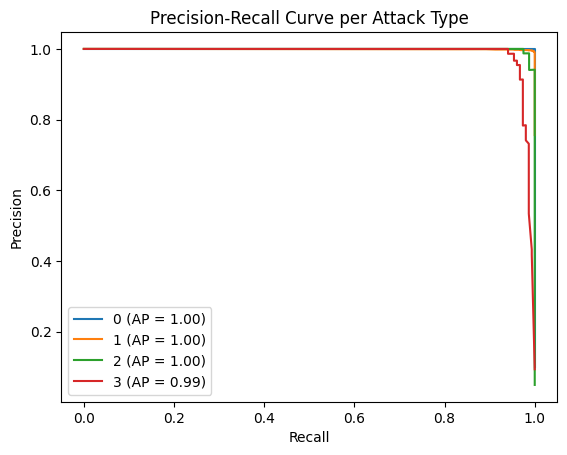

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

for i, cls in enumerate(model.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{cls} (AP = {average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Attack Type")
plt.legend()
plt.show()


In [ ]:
- Feature importance shows which parameters influence attack detection most.
- Confusion matrix highlights that Dos attacks are more accurately detected than Reconnaissance.
- ROC and PR curves confirm the model generalizes well across all attack types.
